Importing libraries

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from PIL import Image
import os

We define a custom dataset class `CustomCocoDataset` that extends `CocoDetection` to load COCO-format data for object and keypoint detection tasks. It preprocesses the dataset by extracting and converting bounding boxes, labels, and keypoints into PyTorch tensors, and applies optional image transformations. The class returns these processed items in a format suitable for training object detection models in PyTorch.

In [36]:
class CustomCocoDataset(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        super(CustomCocoDataset, self).__init__(root, annFile)
        self.transform = transform
    def __getitem__(self, index):
        img, target = super(CustomCocoDataset, self).__getitem__(index)
        target = self._process_target(target)
        if self.transform is not None:
            img = self.transform(img)
        return img, target
    def _process_target(self, target):
        boxes = [obj["bbox"] for obj in target]
        labels = [obj["category_id"] for obj in target]
        keypoints = [obj["keypoints"] for obj in target if "keypoints" in obj]
        face_keypoints_indices = [0, 1, 2, 3, 4, 5, 6]
        keypoints = [[kp[i * 3:(i + 1) * 3] for i in face_keypoints_indices] for kp in keypoints]
        boxes = [[x, y, x + w, y + h] for x, y, w, h in boxes]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        keypoints_flat = [kp for sublist in keypoints for kp in sublist]
        keypoints_tensor = torch.as_tensor(keypoints_flat, dtype=torch.float32)
        num_keypoints = len(face_keypoints_indices)
        keypoints_tensor = keypoints_tensor.view(-1, num_keypoints, 3)
        return {"boxes": boxes, "labels": labels, "keypoints": keypoints_tensor}

we define paths of train , test and valid with their annotations in coco format, we then devide each into batch size of 4 and shuffle it for more robustness and load it for further process

In [37]:
train_dataset = CustomCocoDataset(root='/content/drive/MyDrive/ssdtrainingnew',
                                  annFile='/content/_annotationstrain.coco.json',
                                  transform=ToTensor())
val_dataset = CustomCocoDataset(root='/content/drive/MyDrive/ssdvalid',
                                annFile='/content/_annotations13.coco.json',
                                transform=ToTensor())
test_dataset = CustomCocoDataset(root='/content/drive/MyDrive/newtest',
                                 annFile='/content/_annotations12.coco.json',
                                 transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


we define a function `get_detection_model` that customizes a pre-trained Keypoint R-CNN model for a specific number of object classes and keypoints. The function replaces the model's box and keypoint predictors to match the specified `num_classes` and `num_keypoints`. It then sets up an optimizer with the SGD algorithm for training the model. The script initializes the model with 2 object classes and 7 keypoints, and configures the optimizer for a training duration of 10 epochs.

In [38]:
def get_detection_model(num_classes, num_keypoints):
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_keypoint = model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels
    model.roi_heads.keypoint_predictor = KeypointRCNNPredictor(in_features_keypoint, num_keypoints)
    return model
num_classes = 2
num_keypoints = 7
model = get_detection_model(num_classes, num_keypoints)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

we train the data for 10 epoch

In [39]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        if isinstance(targets, tuple):
            targets = list(targets)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        running_loss += losses.item()
    print(f"Epoch {epoch}: Loss: {running_loss / len(train_loader)}")
print("Training completed")

Epoch 0: Loss: 8.845765113830566
Epoch 1: Loss: 8.306195894877115
Epoch 2: Loss: 7.910011927286784
Epoch 3: Loss: 7.337490876515706
Epoch 4: Loss: 6.645236015319824
Epoch 5: Loss: 5.721378167470296
Epoch 6: Loss: 5.113339900970459
Epoch 7: Loss: 4.585641860961914
Epoch 8: Loss: 4.060803413391113
Epoch 9: Loss: 3.6618451277414956
Training completed


save the trained model path and also deine the error loop

In [40]:
model_save_path = 'trained_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")
model = get_detection_model(num_classes, num_keypoints)
try:
    model.load_state_dict(torch.load(model_save_path), strict=False)
except RuntimeError as e:
    print(f"Error loading model: {e}")
model.eval()

Model saved to trained_model.pth


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

we deine function, `draw_boxes_and_keypoints`, visualizes bounding boxes and keypoints on an image. It converts the input image to a PIL image if necessary and then uses Matplotlib to plot the image. A rectangle representing the bounding box is drawn, and keypoints are marked with blue dots if they are visible. The image with the annotations is displayed using `plt.show()`.

In [41]:
def draw_boxes_and_keypoints(image, box, keypoints, color='red'):
    if isinstance(image, torch.Tensor):
        image = to_pil_image(image.squeeze(0))
    elif isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    else:
        raise TypeError(f"Unsupported image type: {type(image)}")
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                         fill=False, edgecolor=color, linewidth=3)
    ax.add_patch(rect)
    for kp in keypoints:
        if kp[2] > 0:
            ax.plot(kp[0], kp[1], marker='o', markersize=5, color='blue')
    plt.show()

We define the `visualize_prediction` function to evaluate a trained model on a single image from a dataset and visualize the results. We load the image and make a prediction using the model, extracting and processing the keypoints. We then calculate an adjusted bounding box based on the visible keypoints and print this information. Finally, we call the `draw_boxes_and_keypoints` function to visualize the bounding box and keypoints on the image.

In [42]:
def visualize_prediction(model, dataset, index=0, device='cpu'):
    model.eval()
    with torch.no_grad():
        image, _ = dataset[index]
        image_tensor = image.unsqueeze(0).to(device)
        outputs = model(image_tensor)[0]
        pred_keypoints = outputs['keypoints'].cpu().numpy().reshape(-1, 3)
        face_keypoints_indices = [0, 1, 2, 3, 4, 5, 6]
        visible_keypoints = pred_keypoints[[i for i in face_keypoints_indices if pred_keypoints[i, 2] > 0]]
        if visible_keypoints.shape[0] > 0:
            min_x = np.min(visible_keypoints[:, 0])
            min_y = np.min(visible_keypoints[:, 1])
            max_x = np.max(visible_keypoints[:, 0])
            max_y = np.max(visible_keypoints[:, 1])
            box = [min_x, min_y, max_x, max_y]
            print(f"Adjusted bounding box: {box}")
            print(f"Filtered Keypoints: {visible_keypoints}")
            draw_boxes_and_keypoints(image, box, visible_keypoints, color='red')

visualize the output

Adjusted bounding box: [268.5602, 55.17118, 353.21036, 176.49069]
Filtered Keypoints: [[353.21036  98.27154   1.     ]
 [337.23862  75.92321   1.     ]
 [334.84286 143.76634   1.     ]
 [268.5602  133.39034   1.     ]
 [297.30933  87.89552   1.     ]
 [310.0867   55.17118   1.     ]
 [331.64853 176.49069   1.     ]]


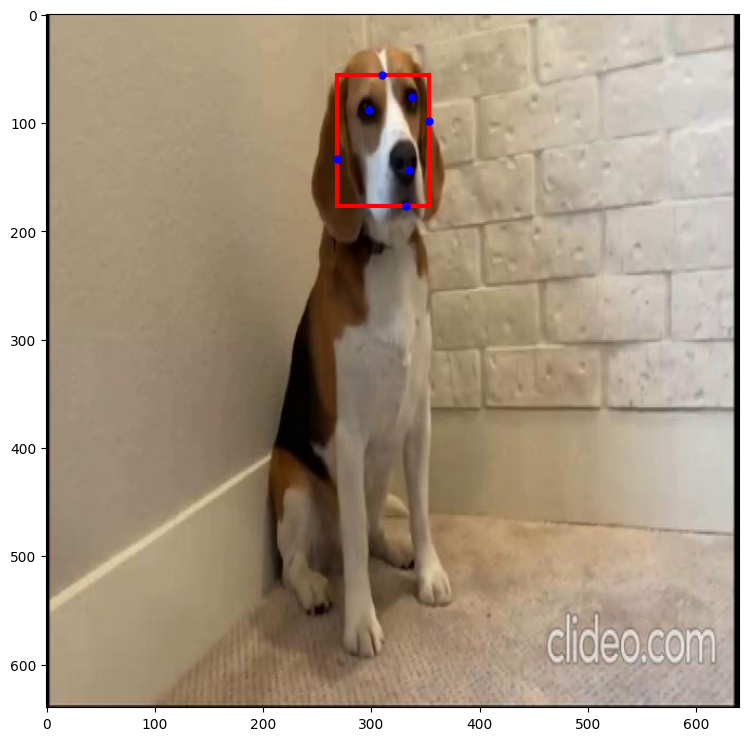

In [43]:
visualize_prediction(model, val_dataset, index=0, device=device)